In [1]:
import networkx as nx
import numpy as np 
from matplotlib import pyplot as plt
import collections
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from scipy.sparse import dok_matrix
from scipy.sparse import csgraph
import time
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
from scipy.sparse.csgraph import minimum_spanning_tree
import scipy.sparse as sps
import json
import pickle
from zahn import Zahn
from template import Template_5
import seaborn as sns

# Load TS and algorithms

In [2]:
with open('data/fin_series_no_trends.json') as fp:
    series_26 = json.load(fp)

In [3]:
with open('fin_series.json') as fp:
    series_orig = json.load(fp)

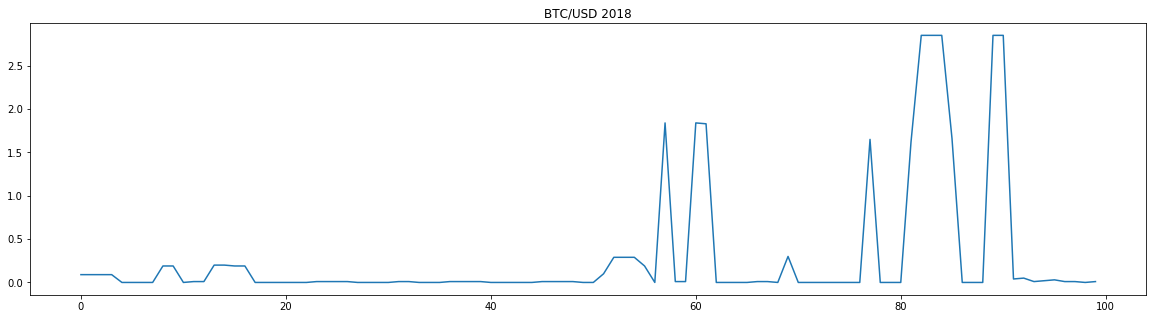

In [18]:
fig, ax1 = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(20,5);
ax1.plot(series_26[:100]);
ax1.set_title("BTC/USD 2018");

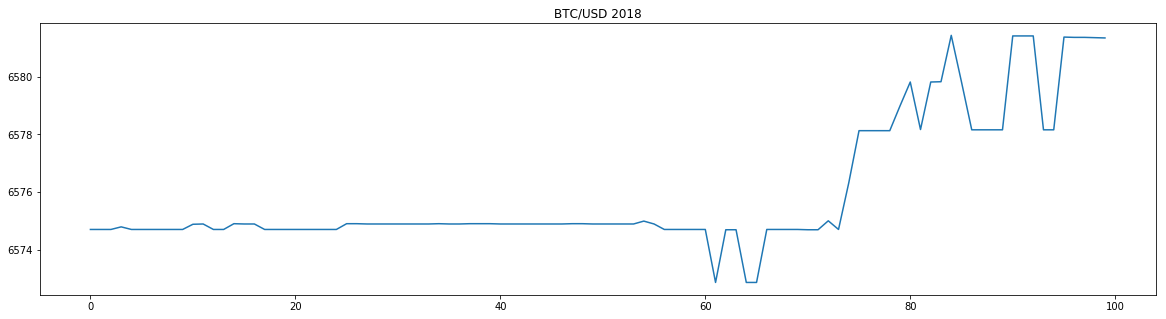

In [19]:
fig, ax1 = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(20,5);
ax1.plot(series_orig[:100]);
ax1.set_title("BTC/USD 2018");

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


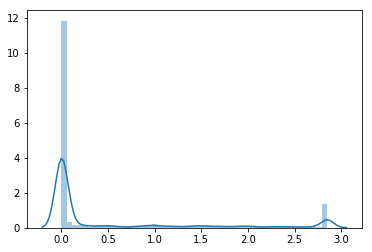

In [20]:
sns.distplot(series_26[:10000])

In [3]:
with open('fitted/zahn_1111', 'rb') as fp:
    zahn_1111 = pickle.load(fp)

In [4]:
with open('fitted/zahn_1112', 'rb') as fp:
    zahn_1112 = pickle.load(fp)

In [5]:
with open('fitted/zahn_1121', 'rb') as fp:
    zahn_1121 = pickle.load(fp)

In [6]:
with open('fitted/zahn_1211', 'rb') as fp:
    zahn_1211 = pickle.load(fp)

In [7]:
with open('fitted/zahn_2111', 'rb') as fp:
    zahn_2111 = pickle.load(fp)

In [8]:
with open('fitted/zahn_1122', 'rb') as fp:
    zahn_1122 = pickle.load(fp)

In [9]:
with open('fitted/zahn_1221', 'rb') as fp:
    zahn_1221 = pickle.load(fp)

In [10]:
with open('fitted/zahn_2211', 'rb') as fp:
    zahn_2211 = pickle.load(fp)

In [11]:
with open('fitted/zahn_1222', 'rb') as fp:
    zahn_1222 = pickle.load(fp)

In [12]:
with open('fitted/zahn_2221', 'rb') as fp:
    zahn_2221 = pickle.load(fp)

In [13]:
def get_averages(zahn):
    comp_fifth_avg = []
    comp_four = []
    for component in zahn.clusters:
        comp_fifth_avg.append(np.mean([i[-1] for i in component]))
        comp = []
        for vec in component:
            comp.append(vec[:-1])
        comp_four.append(np.array(comp))
    centers = np.array([np.mean(x,axis=0) for x in comp_four])
    zahn.comp_fifth_avg = comp_fifth_avg
    zahn.comp_four = comp_four
    zahn.centers = centers
    zahn.centers_ktree = cKDTree(data=centers)

In [14]:
get_averages(zahn_1111)
get_averages(zahn_1112)
get_averages(zahn_1121)
get_averages(zahn_1211)
get_averages(zahn_2111)
get_averages(zahn_1122)
get_averages(zahn_1221)
get_averages(zahn_2211)
get_averages(zahn_1222)
get_averages(zahn_2221)

In [15]:
test = series_26[749993:]
# starting point 750k
start_ind = 7

In [16]:
algos = [
    zahn_1111,
    zahn_1112,
    zahn_1121,
    zahn_1211,
    zahn_2111,
    zahn_1122,
    zahn_1221,
    zahn_2211,
    zahn_1222,
    zahn_2221
]

In [48]:
for algo in algos:
    clusters = [len(x) for x in algo.clusters]
    print(np.mean(clusters), np.max(clusters))

25.042153484071616 894
24.71713214541472 720
24.759968202167272 873
24.484148307361632 820
24.89450291416831 826
24.038048861010235 1381
24.033267212166294 891
24.10320065654493 766
23.846112333430195 1447
23.968612105569893 2136


In [17]:
def get_zvecs_for_prediction(series,i,short=False):
    vec_1111 = series[i-4:i]
    vec_1112 = series[i-5:i-1]
    vec_1121 = np.array([series[i-5],series[i-4],series[i-3],series[i-1]])
    vec_1211 = np.array([series[i-5],series[i-4],series[i-2],series[i-1]])
    vec_2111 = np.array([series[i-5],series[i-3],series[i-2],series[i-1]])
    vec_1122 = np.array([series[i-6],series[i-5],series[i-4],series[i-2]])
    vec_1221 = np.array([series[i-6],series[i-5],series[i-3],series[i-1]])
    vec_2211 = np.array([series[i-6],series[i-4],series[i-2],series[i-1]])
    vec_1222 = np.array([series[i-7],series[i-6],series[i-4],series[i-2]])
    vec_2221 = np.array([series[i-7],series[i-5],series[i-3],series[i-1]])
    vecs = [vec_1111,vec_1112,vec_1121,vec_1211,vec_2111,vec_1122,vec_1221,vec_2211,vec_1222,vec_2221]
    if short:
        vecs = vecs[:-2]
    return vecs

In [18]:
def predict_zvec(zahn,zvec):
    dist,ind = zahn.centers_ktree.query(zvec)
    pred = zahn.comp_fifth_avg[ind]
    return pred, dist

In [19]:
def predict_point(series,i,short=False):
    min_dist = 100000
    cur_pred = 0
    zvecs_list = get_zvecs_for_prediction(series,i,short)
    for i in range(len(zvecs_list)):
        pred, dist = predict_zvec(algos[i],zvecs_list[i])
        if dist < min_dist:
            min_dist = dist
            cur_pred = pred
    return cur_pred,min_dist

In [20]:
def predict_point_avg(series,i):
    preds = []
    dists = []
    zvecs_list = get_zvecs_for_prediction(series,i)
    for i in range(len(zvecs_list)):
        pred, dist = predict_zvec(algos[i],zvecs_list[i])
        preds.append(pred)
        dists.append(dist)
    return np.mean(preds), np.mean(dists)

In [21]:
predict_point(test,500)

(1.9549491672775845, 0.11527055962862438)

In [22]:
test[500]

2.1566097514564335

In [82]:
preds_len = 1000

In [83]:
def get_preds(series,start,n=10):
    preds = []
    dists = []
    errors = []
    sq_errors = []
    step = 0
    series_dummy = series[:start]
    for i in range(start,start+preds_len):
        if step >= n:
            preds.append(series[i])
            series_dummy.append(series[i])
            step += 1
            if step == n + 7:
                step = 0
        else:
            pred, dist = predict_point_avg(series_dummy,i)
            dists.append(dist)
            preds.append(pred)
            errors.append(abs(series[i]-pred) / max(series))
            mse = (series[i] / max(series) - pred/ max(series))**2
            sq_errors.append(mse)
            series_dummy.append(pred)
            step += 1
    return preds, dists, np.mean(errors), np.mean(sq_errors), np.mean(sq_errors)**(1/2)

In [78]:
preds, dists, mae, mse, rmse = get_preds(test,start_ind)

In [26]:
max(test)

18.668867657485308

In [27]:
min(test)

-18.342024814279775

In [84]:
vals = [i for i in range(5,55,5)]
maes = []
mses = []
rmses = []
for val in vals:
    preds,dists, mae, mse, rmse = get_preds(test, start_ind,n=val)
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)

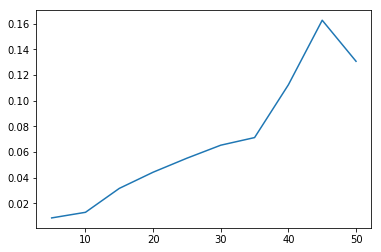

In [29]:
plt.plot(vals,results)

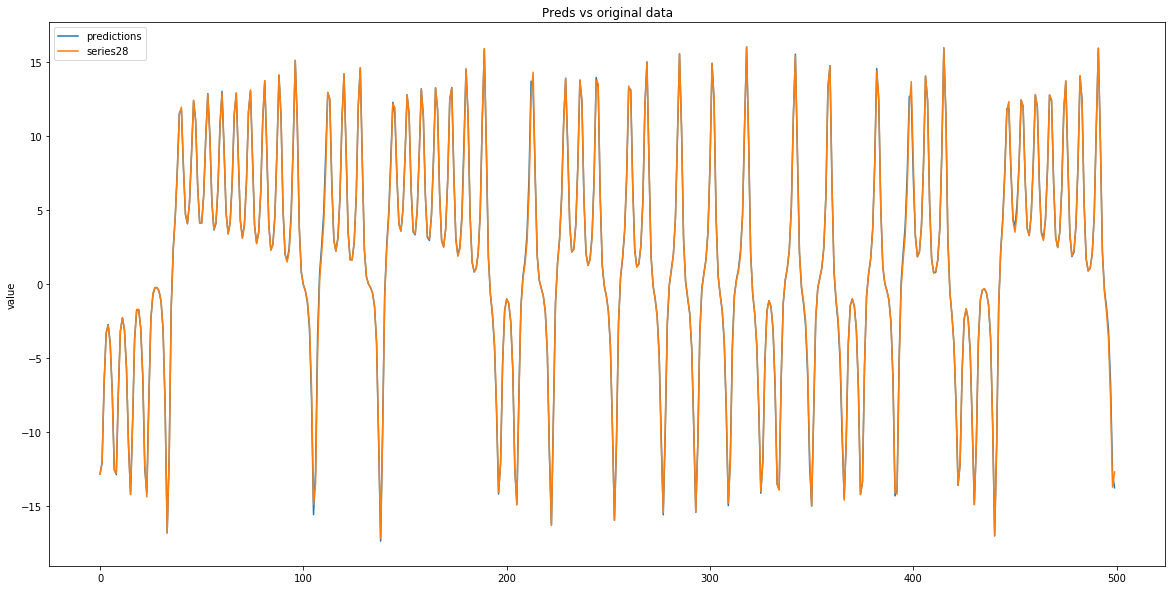

In [65]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(preds_len)], preds[:preds_len], label='predictions')
plt.plot([i for i in range(preds_len)], test[start_ind:start_ind+preds_len], label='series28')
plt.title('Preds vs original data')
plt.ylabel('value')
plt.legend()
plt.show()

In [32]:
def mse(true,pred):
    mse_ = 0
    for i in range(len(true)):
        mse_ += (true[i]-pred[i])**2
    return mse_/len(true)

In [33]:
from sklearn.metrics import mean_absolute_error

In [34]:
mean_absolute_error(test[start_ind:start_ind+preds_len], preds)

2.1498708098973984

In [35]:
test[7:17]

[-12.832920091505308,
 -12.017281986363082,
 -6.6552614266298145,
 -3.2893382502469244,
 -2.7858418081019156,
 -4.061995139340559,
 -7.4081092294902,
 -12.577026366128136,
 -12.770000261012365,
 -7.213399367013812]

In [36]:
from seaborn import distplot

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


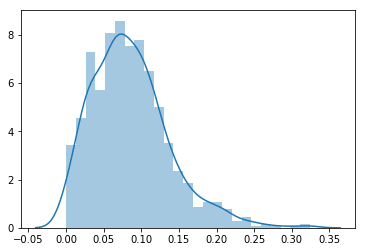

In [37]:
distplot(dists)

In [80]:
def predict_point_eps(series,i,eps, true_val):
    min_dist = 100000
    cur_pred = 0
    zvecs_list = get_zvecs_for_prediction(series,i)
    preds = []
    dists = []
    eps_holds = []
    for i in range(len(zvecs_list)):
        pred, dist = predict_zvec(algos[i],zvecs_list[i])
        preds.append(pred)
        dists.append(dist)
        eps_hold = 1*(abs(true_val - pred) < eps)
        eps_holds.append(eps_hold)
        if dist < min_dist:
            min_dist = dist
            cur_pred = pred
    if sum(eps_holds) == 0:
        return cur_pred,min_dist
    inds = np.where(np.array(eps_holds) > 0)[0]
    dists = [dists[i] for i in inds]
    preds = [preds[i] for i in inds]
    return np.mean(preds), np.mean(dists)

In [81]:
def get_preds_eps(series,start,n=20,eps=0.2):
    preds = []
    dists = []
    errors = []
    sq_errors = []
    step = 0
    series_dummy = series[:start]
    for i in range(start,start+preds_len):
        if step >= n:
            preds.append(series[i])
            series_dummy.append(series[i])
            step += 1
            if step == n + 7:
                step = 0
        else:
            pred, dist = predict_point_eps(series_dummy,i,eps, series[i])
            dists.append(dist)
            preds.append(pred)
            errors.append(abs(series[i]-pred) / max(series))
            mse = (series[i] / max(series) - pred/max(series))**2
            sq_errors.append(mse)
            series_dummy.append(pred)
            step += 1
    return preds, dists, np.mean(errors), np.mean(sq_errors), np.mean(sq_errors)**(1/2)

In [75]:
preds_eps, dists_eps, mae_eps = get_preds_eps(test,start_ind,n=50)

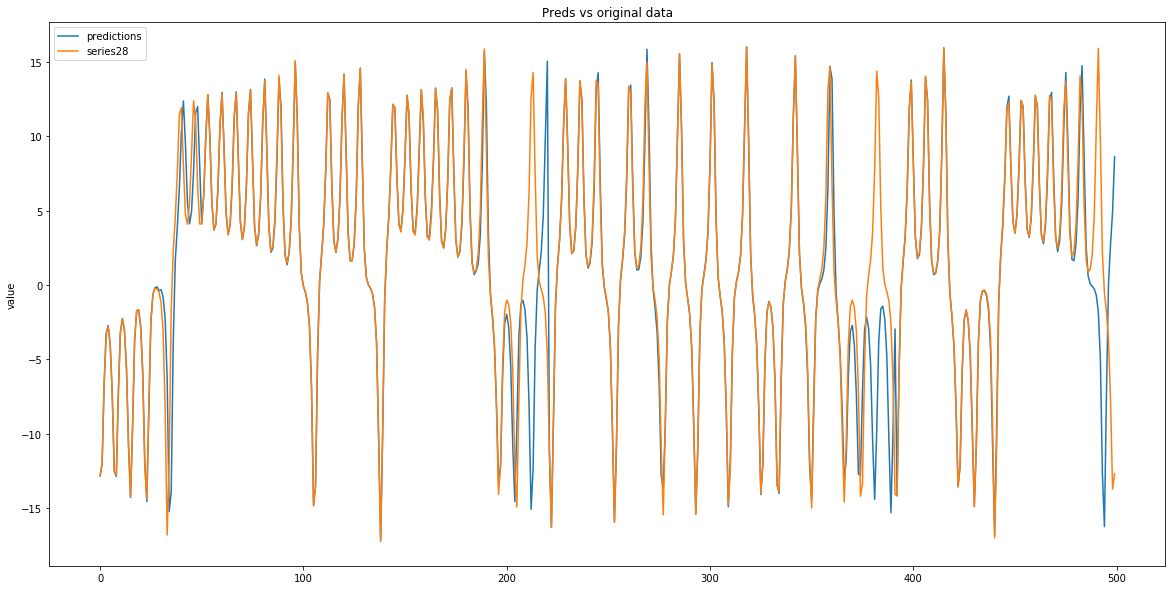

In [76]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(preds_len)], preds_eps[:preds_len], label='predictions')
plt.plot([i for i in range(preds_len)], test[start_ind:start_ind+preds_len], label='series28')
plt.title('Preds vs original data')
plt.ylabel('value')
plt.legend()
plt.show()

In [85]:
vals = [i for i in range(5,55,5)]
maes_eps = []
mses_eps = []
rmses_eps = []
for val in vals:
    preds,dists, mae, mse, rmse = get_preds_eps(test, start_ind,n=val,eps=0.2)
    maes_eps.append(mae)
    mses_eps.append(mse)
    rmses_eps.append(rmse)

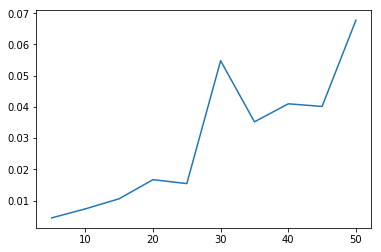

In [44]:
plt.plot(vals,results_eps)

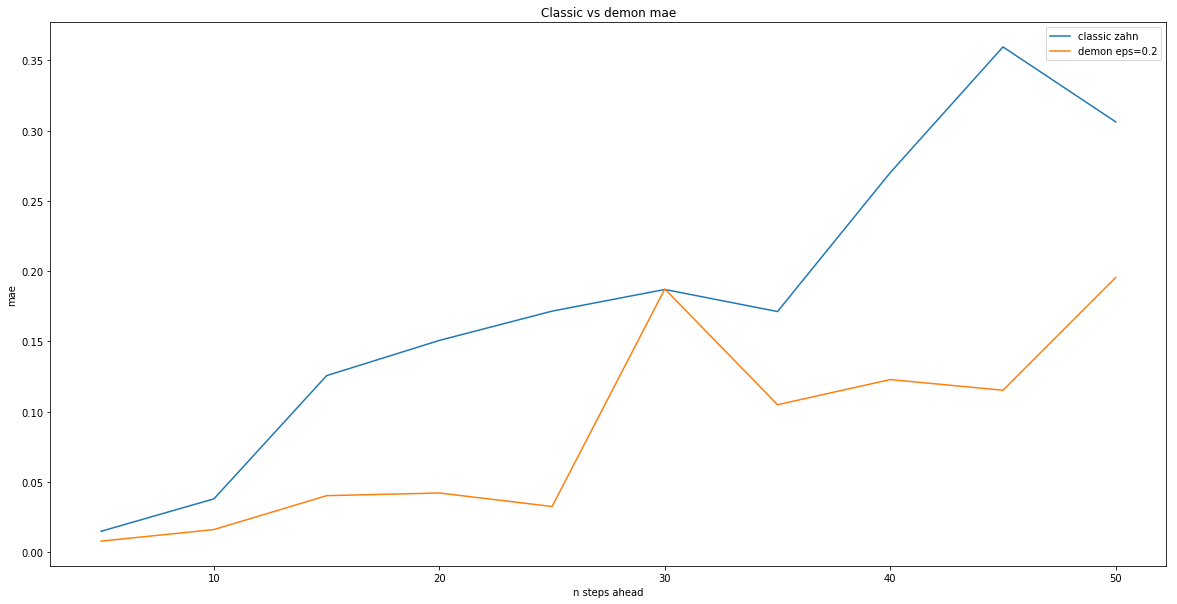

In [88]:
plt.figure(figsize=(20,10))
plt.plot(vals, rmses, label='classic zahn')
plt.plot(vals, rmses_eps, label='demon eps=0.2')
plt.title('Classic vs demon mae')
plt.ylabel('mae')
plt.xlabel('n steps ahead')
plt.legend()
plt.show()

In [176]:
def get_preds_lle(series,start,n=100):
    preds = []
    dists = []
    errors = []
    errors_mat = []
    step = 0
    series_dummy = series[:start]
    for i in range(start,start+preds_len):
        if step >= n:
            if errors:
                errors_mat.append(np.log(np.array(errors)))
                errors = []
            preds.append(series[i])
            series_dummy.append(series[i])
            step += 1
            if step == n + 7:
                step = 0
        else:
            pred, dist = predict_point(series_dummy,i)
            dists.append(dist)
            preds.append(pred)
            errors.append(abs(series[i]-pred))
            series_dummy.append(pred)
            step += 1
    mat = np.array(errors_mat).T
    ks = np.array([i for i in range(1,n+1)]).reshape(n,1)
    return np.linalg.lstsq(ks, mat, rcond=None)[0]

In [177]:
lles = get_preds_lle(test,start_ind)

In [178]:
np.mean(lles)

0.016916696056865885

In [179]:
lles

array([[ 0.00994711,  0.03038292,  0.02206903,  0.01230128,  0.02179256,
         0.01767982, -0.00362136,  0.02673723, -0.01070952,  0.02239481,
         0.02199043, -0.00354829,  0.01748184,  0.02362865,  0.0284117 ,
         0.02829701,  0.02375786,  0.00966826,  0.00926011,  0.0119776 ,
         0.00225498,  0.03033108,  0.02414416, -0.01802243,  0.02182046,
         0.02833159,  0.01949499,  0.02905298,  0.02983587,  0.00773244,
        -0.00836227,  0.01523729,  0.02501273,  0.0176956 ,  0.01576924,
         0.03126675,  0.03118188,  0.0159525 ,  0.02663623,  0.02703756,
         0.01336911,  0.01517687,  0.013011  ,  0.01632282,  0.01694293,
         0.03456147,  0.01413707,  0.00819209,  0.01029267,  0.02246796,
         0.01093015,  0.02613336,  0.00798745,  0.00729986,  0.01363908,
        -0.01975805, -0.01153558,  0.02216371,  0.02266676,  0.00565034,
         0.01462731,  0.01406864,  0.0232169 ,  0.01768728,  0.01443249,
         0.02231472,  0.02547728,  0.01682329,  0.0

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


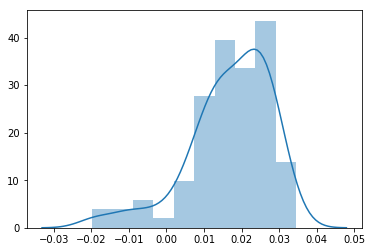

In [182]:
distplot(lles)